# Master MVA- Generative Modeling
### Assignment 25th Feb
### Benjamin Deporte

### Import librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.set_default_dtype(torch.float64)

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(f"Using {device}")

!nvidia-smi

# set seeds for reproductibility
random_seed = 42
rng = np.random.default_rng(seed=random_seed)
torch.manual_seed(random_seed)

Using cpu
/bin/bash: line 1: nvidia-smi: command not found


# 2D-Data

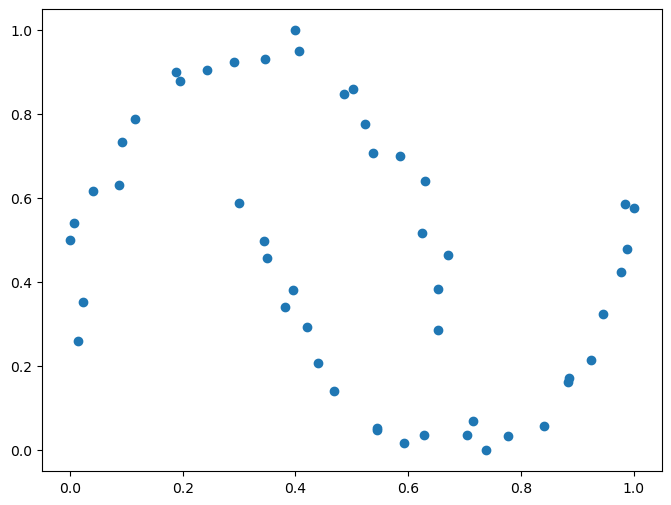

In [3]:
# we will use the two moons dataset here

from sklearn.datasets import make_moons

# parameters
N_SAMPLES = 50
NOISE = 0.05

# generate data
X, _ = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=random_seed)

# force into [0,1]^2
X[:,0] = (X[:,0] - np.min(X[:,0])) / (np.max(X[:,0]) - np.min(X[:,0]))
X[:,1] = (X[:,1] - np.min(X[:,1])) / (np.max(X[:,1]) - np.min(X[:,1]))

# format into tensor
X_data = torch.tensor(X)

# plot dataset
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_data.detach().cpu().numpy()[:,0], X_data.detach().cpu().numpy()[:,1])

plt.show()

# GAN Training

In [4]:
# Generator - we reuse the code from TP

class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=device):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        # create nlayers of nn.Linear of size
        # - n_in for the first one
        # - n_hid for the others
        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        # otuput layer, n_out neurons then Sigmoid
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()

In [5]:
n_in = 10    # input dimension, dimension of the original Gaussian
d = 2        # dimension of data points

b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
z = torch.randn(b, n_in, device=device)
X_gen = G(z).detach().cpu().numpy()

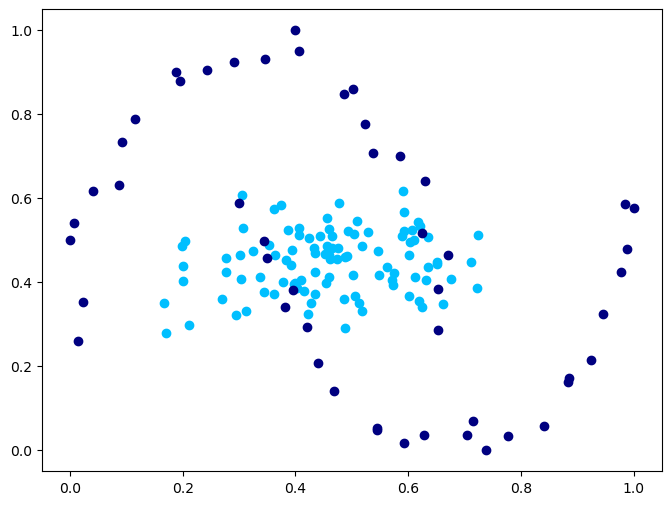

In [6]:
# Sampling test

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X_gen[:,0], X_gen[:,1], c='deepskyblue')
ax.scatter(X_data[:,0], X_data[:,1], c='navy')
plt.show()

In [7]:
# Discriminator - we reuse the code from TP

class DiscriminatorGAN(nn.Module):
  def __init__(self, n_in=2, n_hid=10, device=device):
    super(DiscriminatorGAN, self).__init__()

    # n_in is the input dimension, 2 here as data points are 2D
    self.n_hid = n_hid
    self.n_in = n_in    

    self.fc1 = nn.Linear(n_in, n_hid).to(device)
    self.fc2 = nn.Linear(n_hid, n_hid).to(device)
    self.fc3 = nn.Linear(n_hid, 1).to(device)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    # output probability of the input X being a real data point
    y = nn.Sigmoid()(self.fc3(y))
    return y

### GAN Training Loop

In [ ]:
def train_GAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10
  ):
  
  # Report out
  print(f"Training GAN - GenFreeze={GenFreeze}")
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = 50
  niterD=niterD
  niterG=niterG

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []

  # reporting 
  iter_display = iter_display

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()
        # GAN : no gradient cliping !
        # for p in D.parameters():
        #     p.data.clamp_(-clip_value, clip_value)

      ############################
      ### Train generator (niterG iterations)
      ############################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
        % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data[:,0], X_data[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### First, we fix the generator and make sure the discriminator train

Training GAN - GenFreeze=True
[1/100] 	Loss_D: -0.0178	Loss_G: -0.4638
[2/100] 	Loss_D: -0.0530	Loss_G: -0.4083
[3/100] 	Loss_D: -0.1093	Loss_G: -0.3047
[4/100] 	Loss_D: -0.2023	Loss_G: -0.1808
[5/100] 	Loss_D: -0.2463	Loss_G: -0.1082
[6/100] 	Loss_D: -0.2987	Loss_G: -0.0778
[7/100] 	Loss_D: -0.3148	Loss_G: -0.0516
[8/100] 	Loss_D: -0.3378	Loss_G: -0.0370
[9/100] 	Loss_D: -0.3576	Loss_G: -0.0331
[10/100] 	Loss_D: -0.3590	Loss_G: -0.0360
[11/100] 	Loss_D: -0.3844	Loss_G: -0.0471
[12/100] 	Loss_D: -0.3832	Loss_G: -0.0224
[13/100] 	Loss_D: -0.3764	Loss_G: -0.0361
[14/100] 	Loss_D: -0.3821	Loss_G: -0.0337
[15/100] 	Loss_D: -0.3858	Loss_G: -0.0194
[16/100] 	Loss_D: -0.3756	Loss_G: -0.0223
[17/100] 	Loss_D: -0.3851	Loss_G: -0.0114
[18/100] 	Loss_D: -0.3862	Loss_G: -0.0202
[19/100] 	Loss_D: -0.3879	Loss_G: -0.0312
[20/100] 	Loss_D: -0.3905	Loss_G: -0.0284
[21/100] 	Loss_D: -0.4033	Loss_G: -0.0072
[22/100] 	Loss_D: -0.3808	Loss_G: -0.0244
[23/100] 	Loss_D: -0.4015	Loss_G: -0.0332
[24/100] 	Los

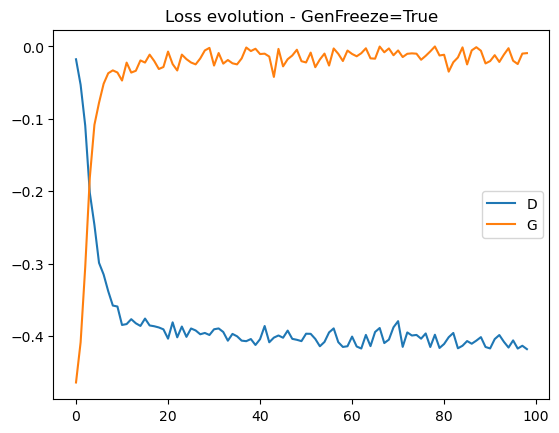

In [9]:
train_GAN(GenFreeze=True, lrdisc=1e-4, iter_display=200)

### Then, we train the Generator also, and give the Discriminator lots of epochs to train

Training GAN - GenFreeze=False
[1/100] 	Loss_D: -0.0496	Loss_G: -0.3663
[2/100] 	Loss_D: -0.1755	Loss_G: -0.1888
[3/100] 	Loss_D: -0.2699	Loss_G: -0.0777
[4/100] 	Loss_D: -0.2476	Loss_G: -0.0622
[5/100] 	Loss_D: -0.2513	Loss_G: -0.0572
[6/100] 	Loss_D: -0.1854	Loss_G: -0.0874
[7/100] 	Loss_D: -0.1570	Loss_G: -0.0920
[8/100] 	Loss_D: -0.0847	Loss_G: -0.1376
[9/100] 	Loss_D: -0.1375	Loss_G: -0.1534
[10/100] 	Loss_D: -0.0774	Loss_G: -0.2206


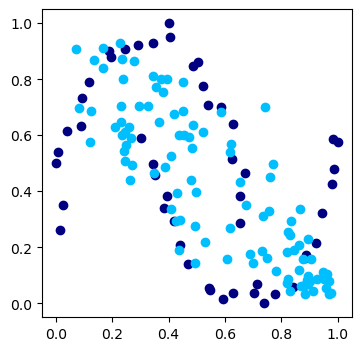

[11/100] 	Loss_D: -0.0799	Loss_G: -0.2796
[12/100] 	Loss_D: 0.0062	Loss_G: -0.2260
[13/100] 	Loss_D: 0.0193	Loss_G: -0.3122
[14/100] 	Loss_D: -0.0438	Loss_G: -0.2745
[15/100] 	Loss_D: -0.0333	Loss_G: -0.2859
[16/100] 	Loss_D: -0.2566	Loss_G: -0.2938
[17/100] 	Loss_D: -0.3869	Loss_G: -0.3044
[18/100] 	Loss_D: -0.3266	Loss_G: -0.4276
[19/100] 	Loss_D: -0.3386	Loss_G: -0.4122
[20/100] 	Loss_D: -0.3678	Loss_G: -0.4580


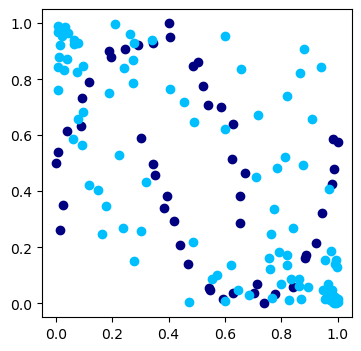

[21/100] 	Loss_D: -0.3397	Loss_G: -0.4665
[22/100] 	Loss_D: -0.3215	Loss_G: -0.4847
[23/100] 	Loss_D: -0.3024	Loss_G: -0.5534
[24/100] 	Loss_D: -0.2738	Loss_G: -0.5807
[25/100] 	Loss_D: -0.2706	Loss_G: -0.6985
[26/100] 	Loss_D: -0.2792	Loss_G: -0.6958
[27/100] 	Loss_D: -0.1559	Loss_G: -0.7153
[28/100] 	Loss_D: -0.1807	Loss_G: -0.6563
[29/100] 	Loss_D: -0.1614	Loss_G: -0.7452
[30/100] 	Loss_D: -0.1116	Loss_G: -0.8290


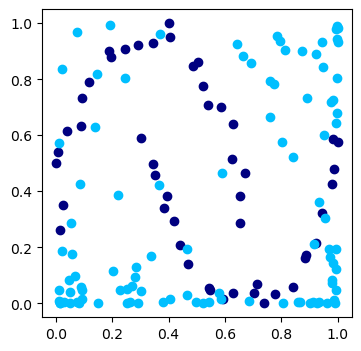

[31/100] 	Loss_D: -0.0664	Loss_G: -0.8237
[32/100] 	Loss_D: -0.0716	Loss_G: -0.8919
[33/100] 	Loss_D: -0.0676	Loss_G: -0.8522
[34/100] 	Loss_D: -0.0160	Loss_G: -0.8710
[35/100] 	Loss_D: -0.0166	Loss_G: -0.9271
[36/100] 	Loss_D: 0.0201	Loss_G: -0.9716
[37/100] 	Loss_D: -0.0089	Loss_G: -0.9881
[38/100] 	Loss_D: -0.0101	Loss_G: -0.9819
[39/100] 	Loss_D: -0.0086	Loss_G: -0.9670
[40/100] 	Loss_D: -0.0062	Loss_G: -0.9897


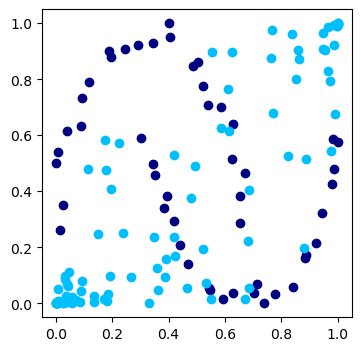

[41/100] 	Loss_D: 0.0014	Loss_G: -0.9989
[42/100] 	Loss_D: 0.0002	Loss_G: -0.9845
[43/100] 	Loss_D: 0.0006	Loss_G: -0.9997
[44/100] 	Loss_D: 0.0002	Loss_G: -0.9999
[45/100] 	Loss_D: 0.0001	Loss_G: -1.0000
[46/100] 	Loss_D: 0.0001	Loss_G: -1.0000
[47/100] 	Loss_D: 0.0001	Loss_G: -1.0000
[48/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[49/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[50/100] 	Loss_D: 0.0000	Loss_G: -1.0000


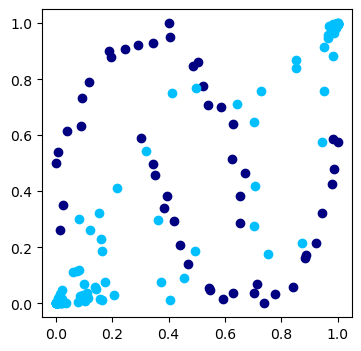

[51/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[52/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[53/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[54/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[55/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[56/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[57/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[58/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[59/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[60/100] 	Loss_D: 0.0000	Loss_G: -1.0000


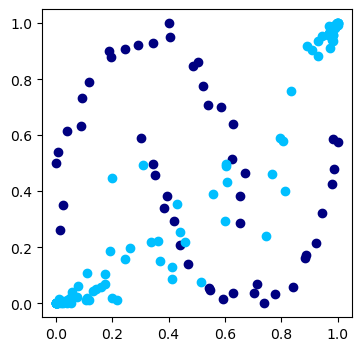

[61/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[62/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[63/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[64/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[65/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[66/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[67/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[68/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[69/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[70/100] 	Loss_D: 0.0000	Loss_G: -1.0000


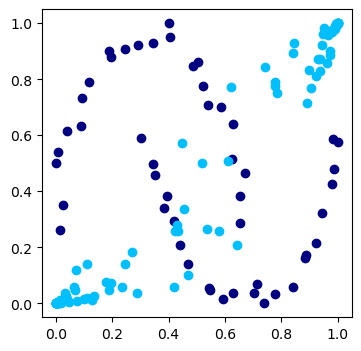

[71/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[72/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[73/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[74/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[75/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[76/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[77/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[78/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[79/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[80/100] 	Loss_D: 0.0000	Loss_G: -1.0000


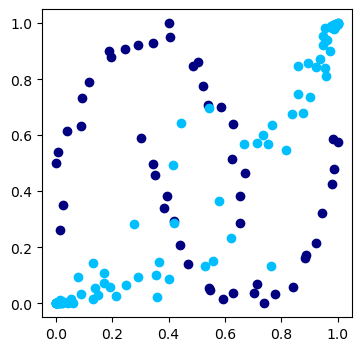

[81/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[82/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[83/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[84/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[85/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[86/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[87/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[88/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[89/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[90/100] 	Loss_D: 0.0000	Loss_G: -1.0000


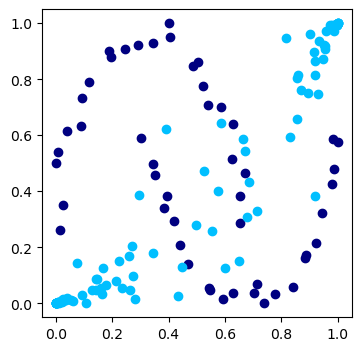

[91/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[92/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[93/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[94/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[95/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[96/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[97/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[98/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[99/100] 	Loss_D: 0.0000	Loss_G: -1.0000


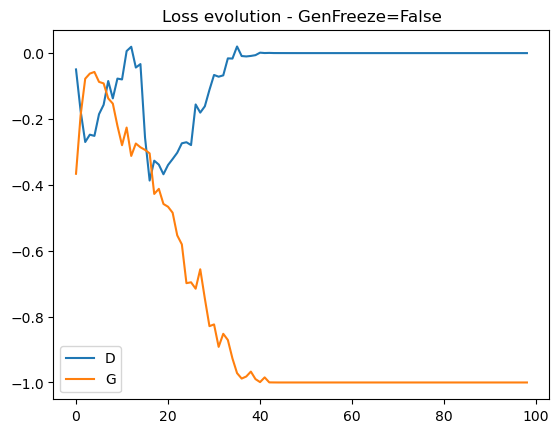

In [10]:
train_GAN(GenFreeze=False, niterD=200, lrdisc=1e-4, iter_display=20)

### Q1.a Comment on the differences with respect to the WGAN learning algorithm.

The vanilla loss of GANs leads to try to optimise a JS divergence, which causes unstable training, as KL divergence goes to infinity when the distribution supports are disjoint.

The WGAN loss is a Wasserstein loss, more precisely uses the dual formulation of W distance, based on Lipschitz function. The training algorithm needs to contain the gradient of the functions (ie by clipping or by gredient-penalty), and the training becomes more stable as the existence of a solution is then garanteed.

### Q1.b. Comment on the possible stability problems that you may encounter with the GAN algorithm.

The issue arises when the support A of the real-data distribution and the support of the generator distribution are disjoint. Then one can find an optimal discriminator that is 1 on A, and 0 elsewhere. Then the gradients do not bring any information (vanishing gradients) and training becomes impossible, or at least unstable.

# WGAN Training

In [11]:
def train_WGAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10,
  lambd = 1.0,
  clip_value = 0.05,
  clip=False,
  grad_penalty=False
  ):
  """WGAN Training - same as GAN, but added regularization
  """
  
  # Report out
  print(f"Training WGAN - GenFreeze={GenFreeze}")
  
  if clip is False and grad_penalty is False:
    print(f"No regularization")
  elif clip is True:
    print(f"Clipping gradient with clip_value = {clip_value}")
  else:
    print(f"Gradient penalty with lambda = {lambd}")
  
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = 50
  niterD=niterD
  niterG=niterG
  lambd=lambd
  clip_value=clip_value

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []
  Gradient_norms = []

  # reporting 
  iter_display = iter_display
  
  # misc
  n_data = X_data.shape[0]

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        g_norm_ests = []
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        
        if grad_penalty is True and clip is False:
          # Estimate Gradient of Discriminator
          
          # Sample points from the generator
          z = torch.randn(n_data, n_in, device=device)
          x = G(z) # shape : N x 2
          # Calculate interpolation between data and generated points
          alpha = torch.rand((n_data,1),device=device) # N x 1
          interp = (alpha * n_data + (1-alpha) * x) # .flatten(end_dim=1) # N x 2
          interp.requires_grad_()
          
          D_interp = D(interp) # N x 1
          gradout = torch.ones(D_interp.size()).to(device) # N x 1
          # autograd will actually compute a Gradient tensor N x 2, as output is N x scalar and input is N x 2
          gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0] # N x 2
          
          est_gradient_norm = torch.mean(torch.sqrt((torch.sum(gradients**2,dim=1)))) # N x 1
          
          # print(f"Gradient norm estimate : {est_gradient_norm}")
          
          g_norm_ests.append(est_gradient_norm.item())
          # # calculate the loss with gradient penalty
          Dloss += lambd * (est_gradient_norm - 1)**2
        
        # clipping gradients if required
        if clip is True and grad_penalty is False:
          for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        # optimize
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()

      if grad_penalty is True and clip is False:
        Gradient_norms.append(np.average(g_norm_ests))

      #######################################
      ### Train generator (niterG iterations)
      #######################################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      if grad_penalty is False:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      else:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f \tGradient_norm_est: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item(), np.average(g_norm_ests)))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data[:,0], X_data[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  # plt.plot(Gradient_norms, label='Gradient Norm Discriminator')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### WGAN-WC

Training WGAN - GenFreeze=True
Clipping gradient with clip_value = 10.0
[1/50] 	Loss_D: -0.3353 	Loss_G: -0.0686
[2/50] 	Loss_D: -0.3623 	Loss_G: -0.0246
[3/50] 	Loss_D: -0.6368 	Loss_G: -0.1249
[4/50] 	Loss_D: -0.6706 	Loss_G: -0.0639
[5/50] 	Loss_D: -0.7132 	Loss_G: -0.0374
[6/50] 	Loss_D: -0.7324 	Loss_G: -0.0491
[7/50] 	Loss_D: -0.7379 	Loss_G: -0.0747
[8/50] 	Loss_D: -0.7552 	Loss_G: -0.0694
[9/50] 	Loss_D: -0.7761 	Loss_G: -0.0461
[10/50] 	Loss_D: -0.7851 	Loss_G: -0.0429
[11/50] 	Loss_D: -0.7841 	Loss_G: -0.0444
[12/50] 	Loss_D: -0.7725 	Loss_G: -0.1136
[13/50] 	Loss_D: -0.7543 	Loss_G: -0.0358
[14/50] 	Loss_D: -0.7826 	Loss_G: -0.0598
[15/50] 	Loss_D: -0.7796 	Loss_G: -0.0445
[16/50] 	Loss_D: -0.7924 	Loss_G: -0.0588
[17/50] 	Loss_D: -0.7609 	Loss_G: -0.0603
[18/50] 	Loss_D: -0.7928 	Loss_G: -0.0544
[19/50] 	Loss_D: -0.7834 	Loss_G: -0.0463
[20/50] 	Loss_D: -0.7727 	Loss_G: -0.0740
[21/50] 	Loss_D: -0.7976 	Loss_G: -0.0492
[22/50] 	Loss_D: -0.7910 	Loss_G: -0.0345
[23/50] 	Loss

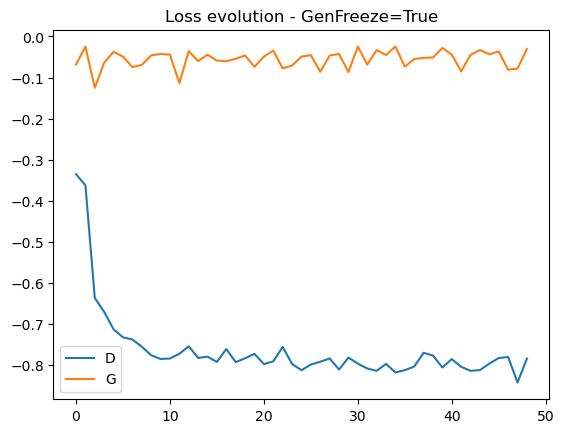

In [12]:
# First, training Discriminator with Generator frozen

train_WGAN(GenFreeze=True, lrdisc=1e-3, niterD=100, clip=True, clip_value=10.0, iter_display=200)

Training WGAN - GenFreeze=False
Clipping gradient with clip_value = 0.5
[1/50] 	Loss_D: -0.6658 	Loss_G: -0.0641
[2/50] 	Loss_D: -0.6536 	Loss_G: -0.0352
[3/50] 	Loss_D: -0.6542 	Loss_G: -0.0806
[4/50] 	Loss_D: -0.5952 	Loss_G: -0.0386
[5/50] 	Loss_D: -0.5662 	Loss_G: -0.1531
[6/50] 	Loss_D: -0.4742 	Loss_G: -0.1655
[7/50] 	Loss_D: -0.4624 	Loss_G: -0.1376
[8/50] 	Loss_D: -0.4171 	Loss_G: -0.2308
[9/50] 	Loss_D: -0.2872 	Loss_G: -0.2921
[10/50] 	Loss_D: -0.3029 	Loss_G: -0.3744
[11/50] 	Loss_D: -0.1705 	Loss_G: -0.4834
[12/50] 	Loss_D: -0.1647 	Loss_G: -0.4632
[13/50] 	Loss_D: -0.1049 	Loss_G: -0.4235
[14/50] 	Loss_D: -0.1292 	Loss_G: -0.5572
[15/50] 	Loss_D: 0.0001 	Loss_G: -0.6134
[16/50] 	Loss_D: -0.1184 	Loss_G: -0.5685
[17/50] 	Loss_D: 0.0685 	Loss_G: -0.6324
[18/50] 	Loss_D: 0.0746 	Loss_G: -0.6765
[19/50] 	Loss_D: 0.0645 	Loss_G: -0.6921
[20/50] 	Loss_D: 0.1390 	Loss_G: -0.7275
[21/50] 	Loss_D: 0.1192 	Loss_G: -0.7180
[22/50] 	Loss_D: 0.1495 	Loss_G: -0.7891
[23/50] 	Loss_D: 0.1

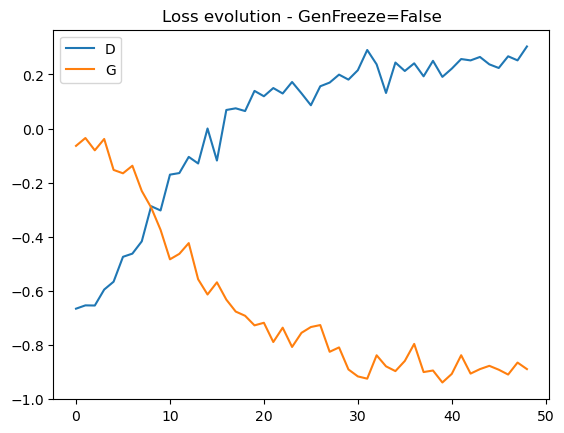

In [18]:
# Then, training both Discriminator and Generator

train_WGAN(GenFreeze=False, niterD=200, lrdisc=1e-3, iter_display=100, clip=True, clip_value=0.5)

### WGAN-GP

Training WGAN - GenFreeze=True
Gradient penalty with lambda = 5.0


[1/50] 	Loss_D: -0.1409 	Loss_G: -0.2732 	Gradient_norm_est: 0.9743
[2/50] 	Loss_D: -0.1902 	Loss_G: -0.1377 	Gradient_norm_est: 1.0758
[3/50] 	Loss_D: -0.1053 	Loss_G: -0.1194 	Gradient_norm_est: 0.8287
[4/50] 	Loss_D: -0.2710 	Loss_G: -0.0813 	Gradient_norm_est: 0.9886
[5/50] 	Loss_D: 0.0703 	Loss_G: -0.0941 	Gradient_norm_est: 0.7420
[6/50] 	Loss_D: -0.2685 	Loss_G: -0.0825 	Gradient_norm_est: 1.0625
[7/50] 	Loss_D: -0.2716 	Loss_G: -0.0708 	Gradient_norm_est: 0.9172
[8/50] 	Loss_D: -0.2983 	Loss_G: -0.0528 	Gradient_norm_est: 0.9948
[9/50] 	Loss_D: -0.2574 	Loss_G: -0.0541 	Gradient_norm_est: 0.9166
[10/50] 	Loss_D: -0.3040 	Loss_G: -0.0901 	Gradient_norm_est: 0.9648
[11/50] 	Loss_D: 0.0928 	Loss_G: -0.0574 	Gradient_norm_est: 0.7093
[12/50] 	Loss_D: -0.2697 	Loss_G: -0.0403 	Gradient_norm_est: 0.9071
[13/50] 	Loss_D: -0.2095 	Loss_G: -0.0892 	Gradient_norm_est: 0.8465
[14/50] 	Loss_D: -0.2721 	Loss_G: -0.0485 	Gradient_norm_est: 1.0909
[15/50] 	Loss_D: -0.3237 	Loss_G: -0.0499 	Gr

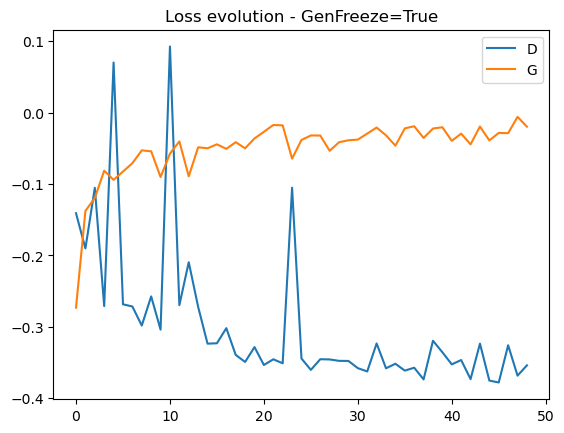

In [19]:
# First, training Discriminator with Generator frozen

train_WGAN(GenFreeze=True, lrdisc=1e-3, niterD=100, grad_penalty=True, lambd=5.0, iter_display=200)

### VAE